In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
#!pip install missingno
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

Shape of application_train.csv: (307511, 122)
Shape of titanic.csv: (891, 12)


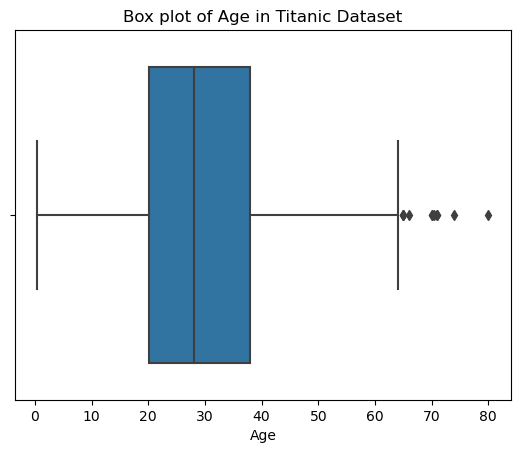

In [7]:
def load_application_train():
    data = pd.read_csv("./dataset/application_train.csv")
    return data

def load_titanic():
    data = pd.read_csv("./dataset/titanic.csv")
    return data

# Load application_train.csv
df_app = load_application_train()
print("Shape of application_train.csv:", df_app.shape)

# Load titanic.csv
df_titanic = load_titanic()
print("Shape of titanic.csv:", df_titanic.shape)

# Box plot for Age column in titanic.csv
sns.boxplot(x=df_titanic["Age"])
plt.title('Box plot of Age in Titanic Dataset')
plt.show()

In [12]:
q1 = df_titanic["Age"].quantile(0.25)
q3 = df_titanic["Age"].quantile(0.75)
iqr = q3 - q1
up = q3 + 1.5 * iqr
low = q1 - 1.5 * iqr

outliers = df_titanic[(df_titanic["Age"] < low) | (df_titanic["Age"] > up)]

print("Outliers in the Age column:")
print(outliers)
print("Indices of outliers in the Age column:")
print(outliers.index)
print("Are there any outliers in the Age column? ", outliers.any(axis=None))
print("Are there any lower bound outliers in the Age column? ", df_titanic[(df_titanic["Age"] < low)].any(axis=None))

Outliers in the Age column:
     PassengerId  Survived  Pclass                                  Name  \
33            34         0       2                 Wheadon, Mr. Edward H   
54            55         0       1        Ostby, Mr. Engelhart Cornelius   
96            97         0       1             Goldschmidt, Mr. George B   
116          117         0       3                  Connors, Mr. Patrick   
280          281         0       3                      Duane, Mr. Frank   
456          457         0       1             Millet, Mr. Francis Davis   
493          494         0       1               Artagaveytia, Mr. Ramon   
630          631         1       1  Barkworth, Mr. Algernon Henry Wilson   
672          673         0       2           Mitchell, Mr. Henry Michael   
745          746         0       1          Crosby, Capt. Edward Gifford   
851          852         0       3                   Svensson, Mr. Johan   

      Sex   Age  SibSp  Parch      Ticket     Fare Cabin Em

In [14]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquartile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquartile_range
    low_limit = quartile1 - 1.5 * interquartile_range
    return low_limit, up_limit

print(outlier_thresholds(df_titanic, "Age")) 

low, up = outlier_thresholds(df_titanic, "Fare")
print(df_titanic[(df_titanic["Fare"] < low) | (df_titanic["Fare"] > up)].head())

(-6.6875, 64.8125)
    PassengerId  Survived  Pclass  \
1             2         1       1   
27           28         0       1   
31           32         1       1   
34           35         0       1   
52           53         1       1   

                                                 Name     Sex   Age  SibSp  \
1   Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
27                     Fortune, Mr. Charles Alexander    male  19.0      3   
31     Spencer, Mrs. William Augustus (Marie Eugenie)  female   NaN      1   
34                            Meyer, Mr. Edgar Joseph    male  28.0      1   
52           Harper, Mrs. Henry Sleeper (Myna Haxtun)  female  49.0      1   

    Parch    Ticket      Fare        Cabin Embarked  
1       0  PC 17599   71.2833          C85        C  
27      2     19950  263.0000  C23 C25 C27        S  
31      0  PC 17569  146.5208          B78        C  
34      0  PC 17604   82.1708          NaN        C  
52      0  PC 17572

In [15]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    return dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None)

print(check_outlier(df_titanic, "Age"))  
print(check_outlier(df_titanic, "Fare"))

True
True


In [16]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O" and col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"num_cols: {len(num_cols)}")
    print(f"cat_but_car: {len(cat_but_car)}")
    print(f"num_but_cat: {len(num_but_cat)}")

    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df_titanic)

Observations: 891
Variables: 12
cat_cols: 6
num_cols: 3
cat_but_car: 3
num_but_cat: 4


In [17]:
num_cols = [col for col in num_cols if col not in ["PassengerId"]]
print(num_cols) 

['Age', 'Fare']


In [18]:
for col in num_cols:
    print(col, check_outlier(df_titanic, col))

Age True
Fare True


In [19]:
dff = load_application_train()

In [22]:
cat_cols, num_cols, cat_but_car = grab_col_names(dff)

Observations: 307511
Variables: 122
cat_cols: 54
num_cols: 67
cat_but_car: 1
num_but_cat: 39


In [23]:
num_cols.remove('SK_ID_CURR')

In [25]:
for col in num_cols:
    print(col, check_outlier(dff, col))

CNT_CHILDREN True
AMT_INCOME_TOTAL True
AMT_CREDIT True
AMT_ANNUITY True
AMT_GOODS_PRICE True
REGION_POPULATION_RELATIVE True
DAYS_BIRTH False
DAYS_EMPLOYED True
DAYS_REGISTRATION True
DAYS_ID_PUBLISH False
OWN_CAR_AGE True
CNT_FAM_MEMBERS True
HOUR_APPR_PROCESS_START True
EXT_SOURCE_1 False
EXT_SOURCE_2 False
EXT_SOURCE_3 False
APARTMENTS_AVG True
BASEMENTAREA_AVG True
YEARS_BEGINEXPLUATATION_AVG True
YEARS_BUILD_AVG True
COMMONAREA_AVG True
ELEVATORS_AVG True
ENTRANCES_AVG True
FLOORSMAX_AVG True
FLOORSMIN_AVG True
LANDAREA_AVG True
LIVINGAPARTMENTS_AVG True
LIVINGAREA_AVG True
NONLIVINGAPARTMENTS_AVG True
NONLIVINGAREA_AVG True
APARTMENTS_MODE True
BASEMENTAREA_MODE True
YEARS_BEGINEXPLUATATION_MODE True
YEARS_BUILD_MODE True
COMMONAREA_MODE True
ELEVATORS_MODE True
ENTRANCES_MODE True
FLOORSMAX_MODE True
FLOORSMIN_MODE True
LANDAREA_MODE True
LIVINGAPARTMENTS_MODE True
LIVINGAREA_MODE True
NONLIVINGAPARTMENTS_MODE True
NONLIVINGAREA_MODE True
APARTMENTS_MEDI True
BASEMENTAREA_MEDI 

In [26]:
def grab_outliers(dataframe, col_name, outlier_index=False, f = 5):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head(f))
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if outlier_index:
        out_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return out_index

In [37]:
age_index = check_outlier(df_titanic, "Age")
print("Outlier indices in 'Age' column:")
print(age_index)

Outlier indices in 'Age' column:
True


In [39]:
print("\nOutliers in 'Age' column:")
grab_outliers(df_titanic, "Age")


Outliers in 'Age' column:
     PassengerId  Survived  Pclass                            Name   Sex  \
33            34         0       2           Wheadon, Mr. Edward H  male   
54            55         0       1  Ostby, Mr. Engelhart Cornelius  male   
96            97         0       1       Goldschmidt, Mr. George B  male   
116          117         0       3            Connors, Mr. Patrick  male   
280          281         0       3                Duane, Mr. Frank  male   

      Age  SibSp  Parch      Ticket     Fare Cabin Embarked  
33   66.0      0      0  C.A. 24579  10.5000   NaN        S  
54   65.0      0      1      113509  61.9792   B30        C  
96   71.0      0      0    PC 17754  34.6542    A5        C  
116  70.5      0      0      370369   7.7500   NaN        Q  
280  65.0      0      0      336439   7.7500   NaN        Q  


In [40]:
print(age_index)

True


In [42]:
df = load_titanic()

In [44]:
low, up = outlier_thresholds(df, "Fare")

In [46]:
print(df.shape)

(891, 12)


In [47]:
print(df[~((df["Fare"] < low) | (df["Fare"] > up))].shape) 

(775, 12)


In [48]:
def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers

In [49]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 891
Variables: 12
cat_cols: 6
num_cols: 3
cat_but_car: 3
num_but_cat: 4


In [50]:
num_cols.remove('PassengerId')

In [51]:
for col in num_cols:
    df = remove_outlier(df,col)

In [52]:
print(df.shape)

(765, 12)


In [53]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [54]:
df = load_titanic()

In [55]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 891
Variables: 12
cat_cols: 6
num_cols: 3
cat_but_car: 3
num_but_cat: 4


In [56]:
num_cols.remove('PassengerId')

In [57]:
for col in num_cols:
    print(col, check_outlier(df, col))

Age True
Fare True


In [58]:
for col in num_cols:
    replace_with_thresholds(df, col)

In [59]:
for col in num_cols:
    print(col, check_outlier(df, col))

Age False
Fare False
